# Assignment 4

**(a)** Plot the data points: radial velocity versus distance.

In [237]:
ss <- read.table("hubbledata.txt", header=TRUE, comment.char="#")

In [240]:
head(ss)

object,distance,radialvelocity
SMag,0.032,170
LMag,0.034,290
NGC6822,0.214,-130
NGC598,0.263,-70
NGC221,0.275,-185
NGC224,0.275,-220


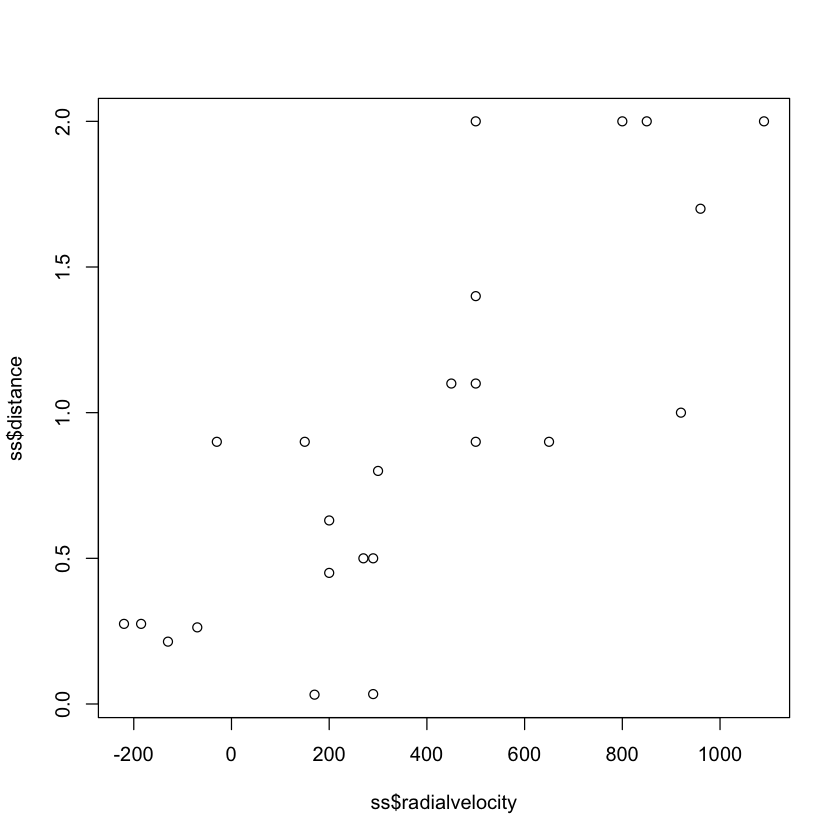

In [201]:
plot(ss$radialvelocity,ss$distance)

**(b)** Consider a normal-theory simple linear regression model of radial velocity on distance of the form

$$
\begin{aligned}
v_i\mid\beta, \sigma^2, D_i \sim \operatorname{indep. N}(\beta_1+\beta_2*D_i,\sigma^2)\quad i=1,...,24
\end{aligned}
$$  

Use independent priors

$$
\begin{aligned}
\beta_1,\beta_2 &\sim \operatorname{iid N}(0,10000^2)\\
\sigma_2 &\sim \operatorname{Inv-gamma}(0.0001,0.0001)
\end{aligned}
$$

(i) List a JAGS model and make sure to use multiple chains with overdispersed starting points, check convergence, and monitor β1, β2, and σ2 for at least 2000 iterations (per chain) after burn-in. As shown in the model check plots, the model reached convergence and no problems with chains.Sample sizes more than adequate.

In [202]:
mod <- lm(radialvelocity ~ distance, data=ss)

In [203]:
summary(mod)


Call:
lm(formula = radialvelocity ~ distance, data = ss)

Residuals:
    Min      1Q  Median      3Q     Max 
-397.96 -158.10  -13.16  148.09  506.63 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -40.78      83.44  -0.489     0.63    
distance      454.16      75.24   6.036 4.48e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 232.9 on 22 degrees of freedom
Multiple R-squared:  0.6235,	Adjusted R-squared:  0.6064 
F-statistic: 36.44 on 1 and 22 DF,  p-value: 4.477e-06


In [204]:
#mod1.bug

'
model {
      for (i in 1:length(y)) {
        y[i] ~ dnorm(beta1 + beta2*x1[i],
sigmasqinv)
}
      beta1 ~ dnorm(0, 10000^2)
      beta2 ~ dnorm(0, 10000^2)
      sigmasqinv ~ dgamma(0.0001, 0.0001)
      sigmasq <- 1/sigmasqinv
    }
'

[1] "\nmodel {\n      for (i in 1:length(y)) {\n        y[i] ~ dnorm(beta1 + beta2*x1[i],\nsigmasqinv)\n}\n      beta1 ~ dnorm(0, 10000^2)\n      beta2 ~ dnorm(0, 10000^2)\n      sigmasqinv ~ dgamma(0.0001, 0.0001)\n      sigmasq <- 1/sigmasqinv\n    }\n"

In [10]:
d1 <- list(y  = ss$radialvelocity, x1 = ss$distance)

In [11]:
#All beta estimates are about -100 to 1000, We choose to set initial bata values at ±10000.
#Regression error variance (sigma_squared) estimate is about 55000, 
#We’ll choose initial sigma_squared values of 100 and 1000000.
inits1 <- list(list(beta1=-10000, beta2=10000,
     sigmasqinv=0.01),
list(beta1=10000, beta2=-10000,
     sigmasqinv=0.01),
list(beta1=10000, beta2=-10000,
     sigmasqinv=0.000001),
list(beta1=10000, beta2=-10000,
     sigmasqinv=0.000001))

In [12]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [13]:
m1 <- jags.model("mod1.bug", d1, inits1, n.chains=4, n.adapt=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 3
   Total graph size: 88

Initializing model



In [14]:
update(m1, 1000)  # burn-in

In [15]:
x1 <- coda.samples(m1, c("beta1","beta2","sigmasq"),
                   n.iter=2000)

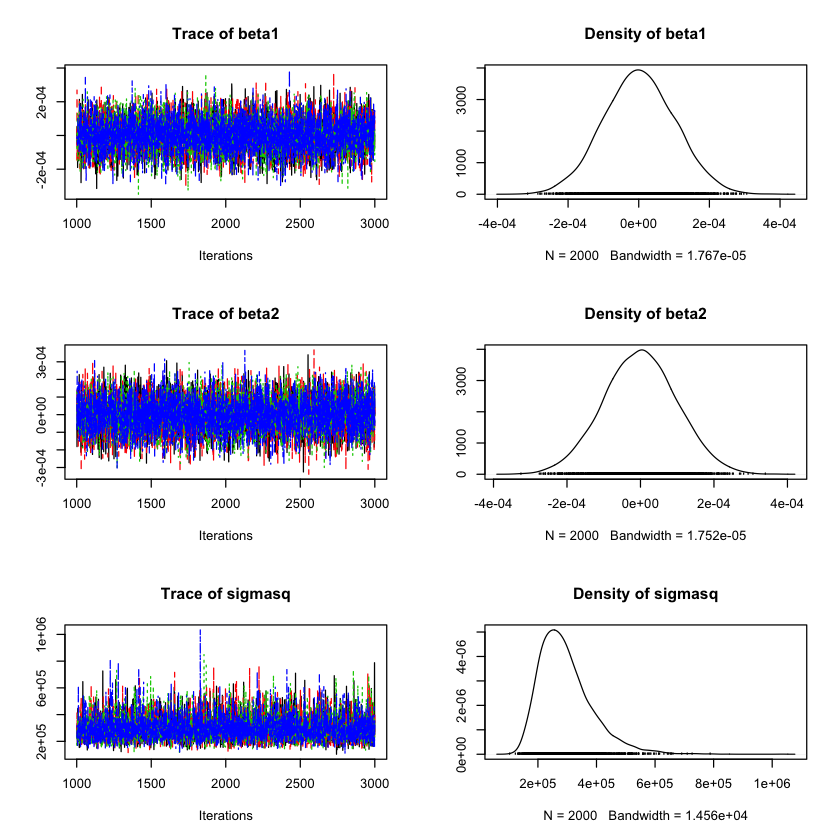

In [16]:
#monitor β1, β2, and σ2 
plot(x1, smooth=FALSE)

Potential scale reduction factors:

        Point est. Upper C.I.
beta1            1          1
beta2            1          1
sigmasq          1          1

Multivariate psrf

1

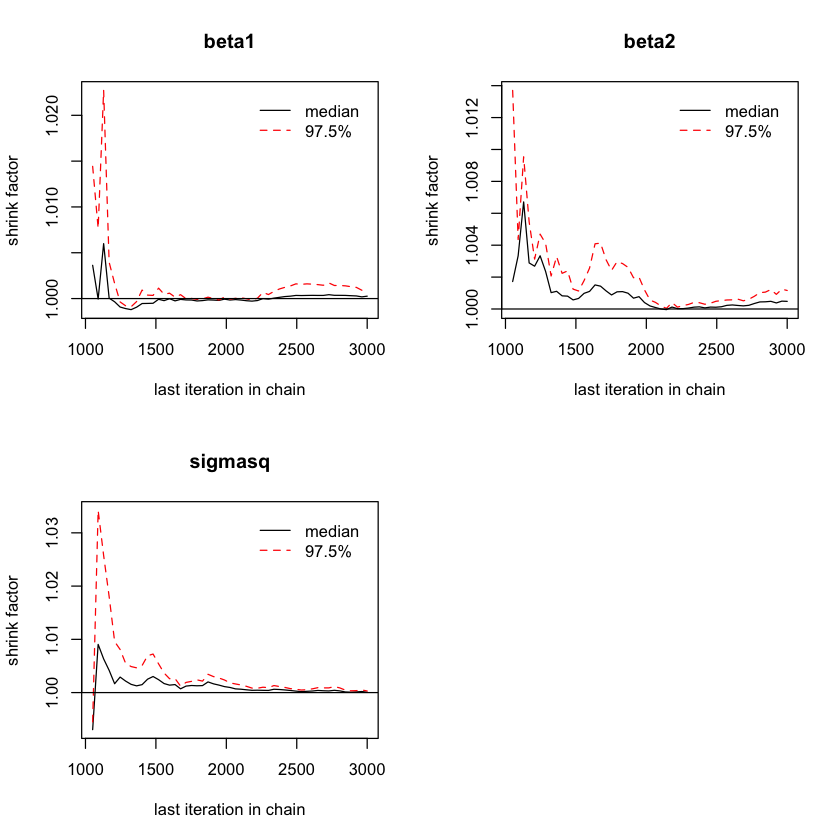

In [17]:
#check convergence
gelman.diag(x1, autoburnin=FALSE)
gelman.plot(x1, autoburnin=FALSE)

In [18]:
effectiveSize(x1)

beta1    beta2  sigmasq 
8522.497 7641.588 8000.000

(ii)List the coda summary of your results for β1, β2, and σ2.

In [19]:
summary(x1)


Iterations = 1001:3000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
beta1    2.123e-06 1.006e-04 1.125e-06      1.095e-06
beta2   -4.843e-07 9.972e-05 1.115e-06      1.142e-06
sigmasq  2.953e+05 9.140e+04 1.022e+03      1.022e+03

2. Quantiles for each variable:

              2.5%        25%        50%       75%     97.5%
beta1   -1.947e-04 -6.627e-05  9.711e-07 6.998e-05 2.013e-04
beta2   -1.959e-04 -6.796e-05 -7.796e-07 6.682e-05 1.958e-04
sigmasq  1.644e+05  2.302e+05  2.794e+05 3.413e+05 5.192e+05


(iii)Give the approximate posterior mean and 95% posterior credible interval for the
slope.  
According to the summary, approximate posterior mean for the $H_0$ is -4.843e-07, which does not appear to be positive. 95% posterior CI is (-1.959e-04,1.958e-04).

(iv)Give the approximate posterior mean and 95% posterior credible interval for the
intercept. (Does your interval contain zero?)  
According to the summary, approximate posterior mean for the intercept is 2.123e-06, 95% posterior CI is (-1.947e-04, 2.013e-04), which contain zero. 

**(c)** Consider the model of the previous part, but without the intercept (i.e., assuming the intercept is zero, as theory predicts). This is sometimes called regression through the origin. Use the same priors as before for the remaining parameters.  
(i)modified JAGS model

In [196]:
#mod2.bug

"
model {
      for (i in 1:length(y)) {
        y[i] ~ dnorm(beta*x1[i],
sigmasqinv)
}
      beta ~ dnorm(0, 10000^2)
      sigmasqinv ~ dgamma(0.0001, 0.0001)
      sigmasq <- 1/sigmasqinv
    }
"

[1] "\nmodel {\n      for (i in 1:length(y)) {\n        y[i] ~ dnorm(beta*x1[i],\nsigmasqinv)\n}\n      beta ~ dnorm(0, 10000^2)\n      sigmasqinv ~ dgamma(0.0001, 0.0001)\n      sigmasq <- 1/sigmasqinv\n    }\n"

In [207]:
mod2 <- lm(radialvelocity ~ 0+distance, data=ss)

In [208]:
summary(mod2)


Call:
lm(formula = radialvelocity ~ 0 + distance, data = ss)

Residuals:
   Min     1Q Median     3Q    Max 
-411.5 -191.3   -7.1  128.0  496.1 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)    
distance   423.94      42.15   10.06 6.87e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 229 on 23 degrees of freedom
Multiple R-squared:  0.8147,	Adjusted R-squared:  0.8067 
F-statistic: 101.1 on 1 and 23 DF,  p-value: 6.869e-10


In [205]:
d2 <- list(y  = ss$radialvelocity, x1 = ss$distance)

In [206]:
#All beta estimates is about 500, We choose to set initial bata values at ±10000.
#Regression error variance (sigma_squared) estimate is about 55000, 
#We’ll choose initial sigma_squared values of 100 and 1000000.
inits2 <- list(list(beta=10000,
     sigmasqinv=0.01),
list(beta=-10000,
     sigmasqinv=0.01),
list(beta=10000,
     sigmasqinv=0.000001),
list(beta=-10000,
     sigmasqinv=0.000001))

In [24]:
m2 <- jags.model("mod2.bug", d2, inits2, n.chains=4, n.adapt=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 24
   Unobserved stochastic nodes: 2
   Total graph size: 72

Initializing model



In [25]:
update(m2, 1000)  # burn-in

In [26]:
x2 <- coda.samples(m2, c("beta","sigmasq"),
                   n.iter=2000)

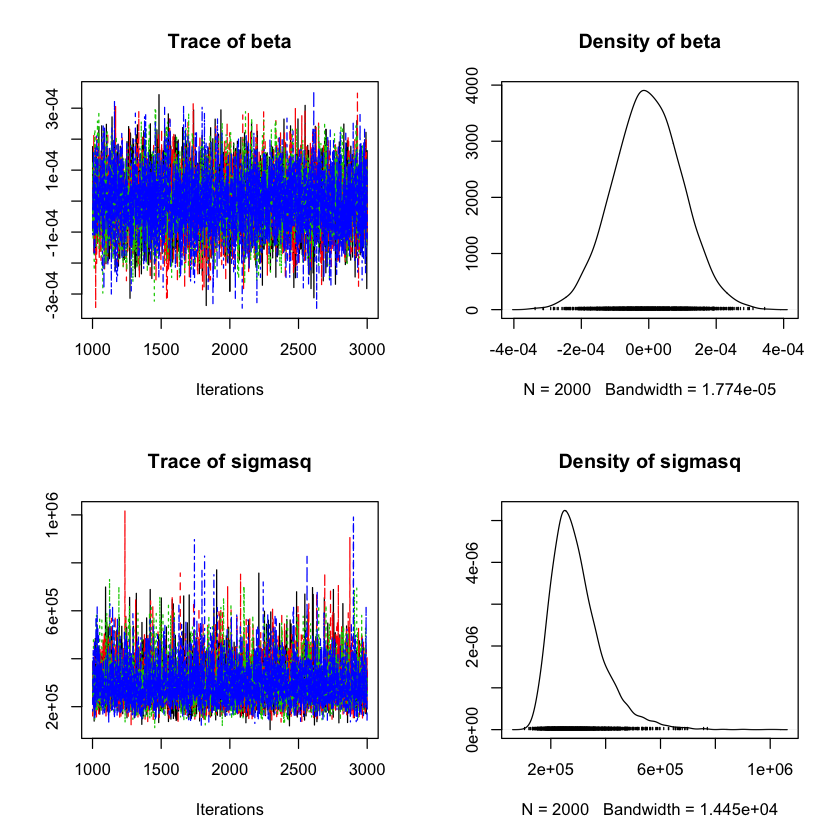

In [27]:
#monitor β, and σ2 
plot(x2, smooth=FALSE)

Potential scale reduction factors:

        Point est. Upper C.I.
beta             1          1
sigmasq          1          1

Multivariate psrf

1

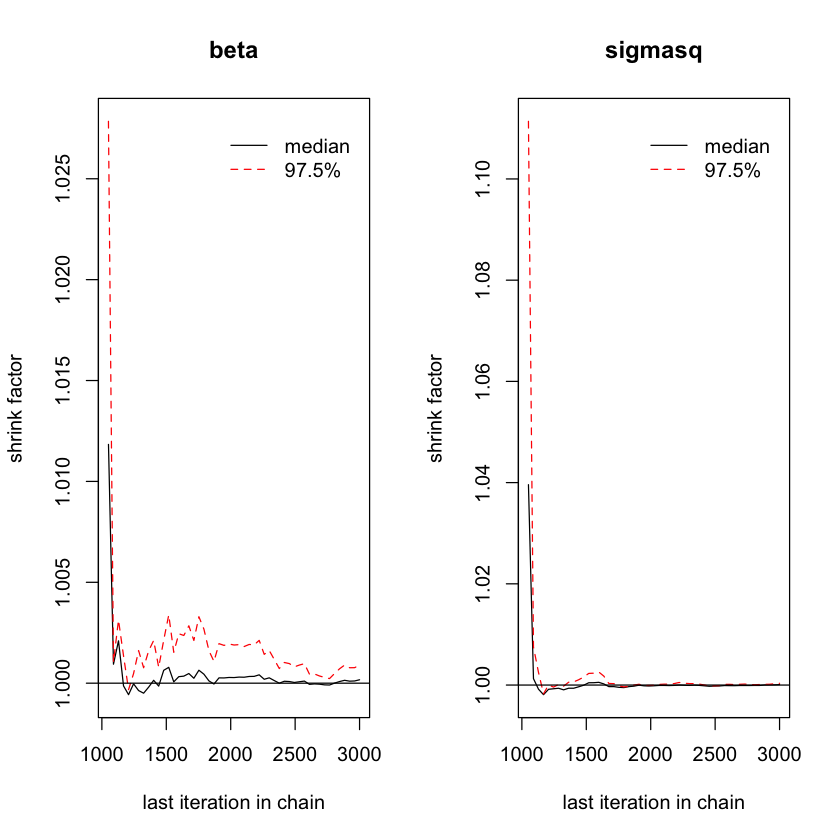

In [28]:
#check convergence
gelman.diag(x2, autoburnin=FALSE)
gelman.plot(x2, autoburnin=FALSE)

In [29]:
effectiveSize(x2)

beta  sigmasq 
8215.948 8812.016

(ii)List the coda summary of your results for all parameters.

In [30]:
summary(x2)


Iterations = 1001:3000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
beta    -2.213e-06 1.010e-04 1.129e-06      1.114e-06
sigmasq  2.964e+05 9.335e+04 1.044e+03      9.965e+02

2. Quantiles for each variable:

              2.5%        25%        50%       75%     97.5%
beta    -1.980e-04 -7.026e-05 -3.116e-06 6.555e-05 1.973e-04
sigmasq  1.642e+05  2.321e+05  2.790e+05 3.423e+05 5.318e+05


(iii)Give the approximate posterior mean and 95% posterior credible interval for the slope.  
According to the summary, approximate posterior mean for the $H_0$ is -2.213e-06, 95% posterior CI is (-1.980e-04,1.973e-04).

(iv)Compare the change in the posterior mean of the slope (versus part (b)) to its posterior standard deviation.  
posterior mean of the slope hasn't changed very much but its posterior standard deviation is wider than before.

**(d)** To check for evidence against the assumption that the intercept is zero is to produce a posterior predictive p value based on the no-intercept model, consider test quantity:  
$$
\begin{aligned}
T(y,X,\theta) = |\widehat{cor}(\epsilon,x_D)|
\end{aligned}
$$

(i)Show R code for computing the simulated error vectors ε (as rows of a matrix).  
Knowing that 
$$
\begin{aligned}
\epsilon_i = y_i-X_i*\beta
\end{aligned}
$$
are conditionally
$$
\begin{aligned}
\operatorname{iid N}(0,\sigma^2) (given \space \theta, X)
\end{aligned}
$$  

for each observation, use rnorm to generate error vector based on posterior $\sigma$

In [209]:
post.samp <- as.matrix(x2)

In [213]:
#(rows = simulations, columns = observations):
Nsim<-nrow(post.samp)
error.sim <- matrix(NA, Nsim, nrow(ss))

In [242]:
#each row is error vector for one simulation
for(s in 1:Nsim){
    for(i in 1:nrow(ss)){        
        error.sim[s,i] <- rnorm(1,0,sqrt(post.samp[s,2]))
        }
    }

(ii)Show R code for computing simulated replicate error vectors ε_rep (as rows of a
matrix), which are the error vectors for the replicate response vectors y.rep.

In [170]:
#matrix for generating replicate posterior y. rows =simulations, cols=observations
y.rep <- matrix(NA, Nsim,nrow(ss))

In [171]:
#fill in the matrix based on linear regression model and parameter
for(s in 1:Nsim){
    for (i in 1:length(ss$distance)){
        y.rep[s,i]<-rnorm(1,post.samp[s,1]*ss$distance[i],sqrt(post.samp[s,2]))
        }
    }

In [172]:
#calculate error for replicate posterior y
error.rep<- matrix(NA, Nsim, nrow(ss))
for(s in 1:Nsim){
    error.rep[s,] <- (y.rep[s,] - ss$distance * post.samp[s,1])
    }

(iii)Show R code for computing the simulated values of $T(y,X,\theta)$ and the simulated
values of $T(y.rep,X,\theta)$.

In [244]:
T_y=abs(cor(t(error.sim),ss$distance))

In [245]:
T_y.rep=abs(cor(t(error.rep),ss$distance))

(iv)Plot the simulated values of $T(y.rep,X,\theta)$ versus those of $T(y,X,\theta)$, with a
reference line indicating where $T(y.rep,X,\theta) = T(y,X,\theta)$.

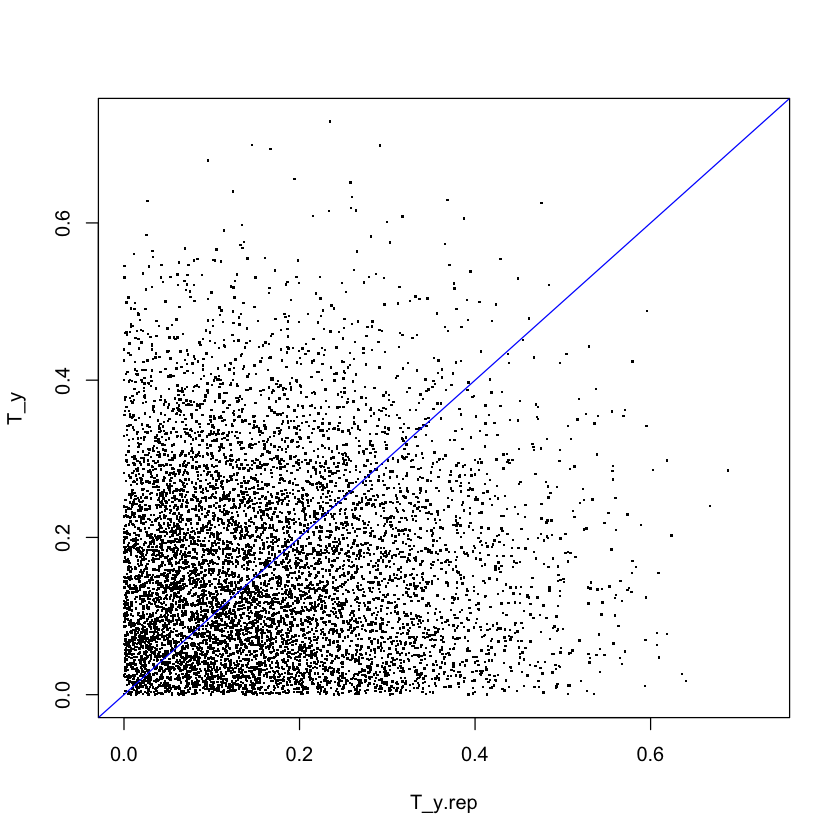

In [246]:
plot(T_y.rep,T_y,pch=".", cex=2,
    xlim=c(min(T_y.rep, T_y), max(T_y.rep, T_y)),
    ylim=c(min(T_y.rep, T_y), max(T_y.rep, T_y)))
abline(a=0,b=1,col="blue")

(v)Compute the approximate posterior predictive p-value, and make an appropriate conclusion based on it.  
As shown below, p=0.50575, which indicates no assymetry between y and y_rep, it suggests that the no-intercept model is a good model.

In [248]:
mean(T_y.rep>=T_y)

[1] 0.50575